Между тем обработалось 378 партий, поэтому можно попробовать их кластеризовать! Если мы увидим чёткие кластеры, тогда признаки были хорошими, иначе информации не хватает и надо дальше думать, как улучшать описание ходов

In [1]:
import pandas as pd
import os
import numpy as np

data = []

path_to_data = 'C:/Users/matvey/Documents/chess_data/tmp/'
for item in os.listdir(path_to_data):
    df = pd.read_csv(path_to_data + item)
    df['game_idx'] = int(item.split('.')[0])
    df['move_idx'] = np.arange(df.shape[0])
    data.append(df)

data = pd.concat(data, axis=0)
data.shape

(25689, 17)

In [2]:
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()
scaled_data = scl.fit_transform(data.drop(['game_idx', 'move_idx'], axis=1))
type(scaled_data)

numpy.ndarray

In [3]:
from sklearn.manifold import TSNE

# Снижение размерности до 2 компонент с помощью t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(scaled_data)

In [4]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=10)  # eps - радиус соседства, min_samples - минимальное число точек в кластере
data['cluster'] = dbscan.fit_predict(scaled_data)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Создание DataFrame для визуализации
tsne_df = pd.DataFrame(data=tsne_result, columns=['TSNE1', 'TSNE2'])
tsne_df['cluster'] = data['cluster'].values

In [6]:
from typing import Literal

def draw_tsne(df, name: str, pallete: Literal['hue', 'random'], legend: Literal['full', 'none', 'auto'] = 'none'):
    # Создание случайной палитры цветов
    unique_clusters = df[name].nunique()  # Определяем количество уникальных кластеров
    random_colors = np.random.rand(unique_clusters, 3)  # Генерируем случайные RGB-цвета
    custom_palette = list(map(tuple, random_colors))  # Преобразуем массив в список кортежей

    # Визуализация с использованием случайных цветов
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x='TSNE1',
        y='TSNE2',
        hue=name,
        palette=custom_palette if pallete == 'random' else 'viridis',  # Используем нашу случайную палитру
        data=df,
        legend=legend if legend != 'none' else 'auto'
    )

    if legend != 'none':
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        plt.legend().remove()

    plt.title('t-SNE: Кластеры')
    plt.show()

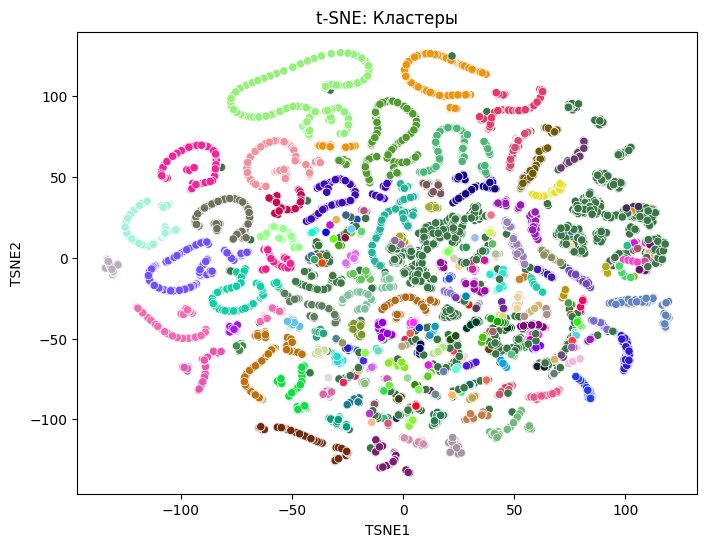

In [7]:
draw_tsne(tsne_df, 'cluster', pallete='random')

Может, полосочки - это один и тот же ход по счёту? Например 1-4 ходы всегда очень похожи

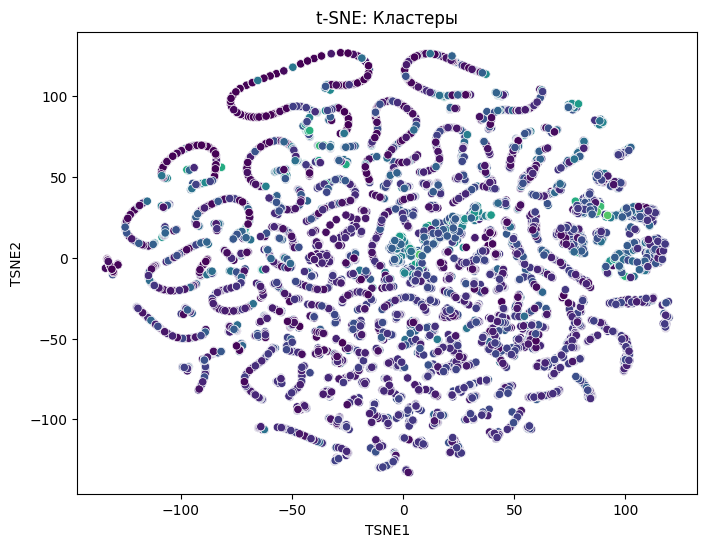

In [8]:
tsne_df['move_idx'] = data['move_idx'].values

draw_tsne(tsne_df, 'move_idx', pallete='hue')

Ближе к правде. Давайте посмотрим, какие данные образуют такие полоски

In [9]:
dbscan = DBSCAN(eps=5, min_samples=5)
tsne_df['weird_line_cluster'] = dbscan.fit_predict(pd.DataFrame(data=tsne_result, columns=['TSNE1', 'TSNE2']))

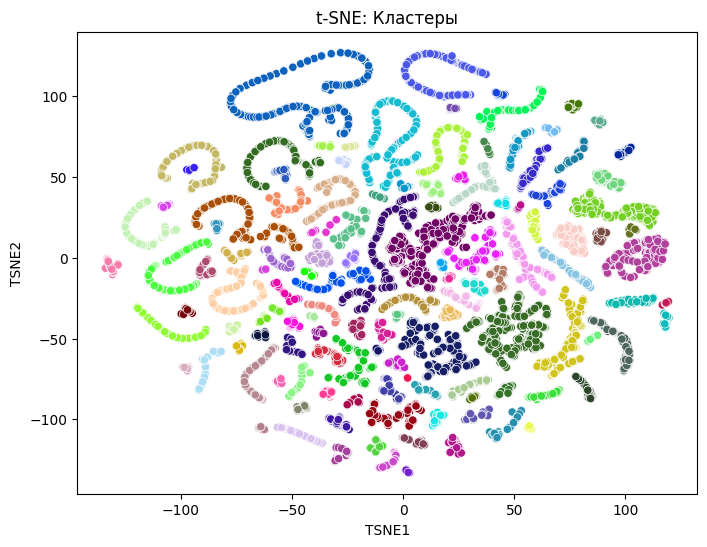

In [10]:
draw_tsne(tsne_df, 'weird_line_cluster', pallete='random')

In [11]:
data_group = data.groupby(tsne_df['weird_line_cluster'])

move_to_frequency = {}
for group_num in data_group.groups.keys():
    group = data_group.get_group(group_num)
    move_idx_count = group['move_idx'].value_counts()
    # move_idx_count = move_idx_count[move_idx_count > 1]
    for move_idx, cnt in move_idx_count.items():
        if move_idx not in move_to_frequency:
            move_to_frequency[move_idx] = {}
        move_to_frequency[move_idx][group_num] = cnt

is_one_cluster_for_every_moveid = True
for move_idx in sorted(move_to_frequency.keys()):
    print(f'Index of Move: {move_idx}', end=';\t')
    print(f'Clusters Frequency: {move_to_frequency[move_idx]}')
    if len(move_to_frequency[move_idx].keys()) > 1:
        is_one_cluster_for_every_moveid = False

print(is_one_cluster_for_every_moveid)

Index of Move: 0;	Clusters Frequency: {0: 377}
Index of Move: 1;	Clusters Frequency: {1: 376}
Index of Move: 2;	Clusters Frequency: {2: 372}
Index of Move: 3;	Clusters Frequency: {2: 372}
Index of Move: 4;	Clusters Frequency: {3: 372}
Index of Move: 5;	Clusters Frequency: {3: 371}
Index of Move: 6;	Clusters Frequency: {4: 371}
Index of Move: 7;	Clusters Frequency: {1: 370}
Index of Move: 8;	Clusters Frequency: {5: 369}
Index of Move: 9;	Clusters Frequency: {5: 369}
Index of Move: 10;	Clusters Frequency: {1: 369}
Index of Move: 11;	Clusters Frequency: {2: 369}
Index of Move: 12;	Clusters Frequency: {6: 368}
Index of Move: 13;	Clusters Frequency: {7: 367}
Index of Move: 14;	Clusters Frequency: {8: 367}
Index of Move: 15;	Clusters Frequency: {9: 365}
Index of Move: 16;	Clusters Frequency: {10: 364}
Index of Move: 17;	Clusters Frequency: {11: 364}
Index of Move: 18;	Clusters Frequency: {12: 364}
Index of Move: 19;	Clusters Frequency: {13: 361}
Index of Move: 20;	Clusters Frequency: {14: 36

Внезапно, если снизить размерность данных с помощью t-SNE, то каждый кластер состоит из объектов, у которых множество номеров ходов очень невелико. Например, нулевой кластер содержит объекты, соответствующие в основном только первому, второму и третьему ходу. Более того, каждый ход входит только в один кластер. Это значит, что t-SNE каким-то образом учитывает номер хода. Иначе говоря, при такой обработке признаки скорее отражают принадлежность некоторому этапу игры, нежели её интересности. 

Но давайте посмотрим всё-таки на оригинальное разбиение на кластеры:

In [12]:
data_group = data.groupby(data['cluster'])

move_to_frequency = {}
for group_num in data_group.groups.keys():
    group = data_group.get_group(group_num)
    move_idx_count = group['move_idx'].value_counts()
    move_idx_count = move_idx_count[move_idx_count > 10]
    for move_idx, cnt in move_idx_count.items():
        if move_idx not in move_to_frequency:
            move_to_frequency[move_idx] = {}
        move_to_frequency[move_idx][group_num] = cnt

is_one_cluster_for_every_moveid = True
for i, move_idx in enumerate(sorted(move_to_frequency.keys())):
    print(f'Index of Move: {move_idx}', end=';\t')
    print(f'Clusters Frequency: {list(sorted(set(move_to_frequency[move_idx].keys())))}')
    if len(move_to_frequency[move_idx].keys()) > 1:
        is_one_cluster_for_every_moveid = False
    
    if i > 5:
        break

print(is_one_cluster_for_every_moveid)

Index of Move: 0;	Clusters Frequency: [0, 1, 2]
Index of Move: 1;	Clusters Frequency: [0, 1, 2, 7]
Index of Move: 2;	Clusters Frequency: [0, 1, 2, 7, 8, 9, 39, 85]
Index of Move: 3;	Clusters Frequency: [1, 2, 7, 8, 9, 40, 53, 114]
Index of Move: 4;	Clusters Frequency: [1, 2, 7, 8, 9, 36, 41, 53, 85, 114, 168]
Index of Move: 5;	Clusters Frequency: [1, 2, 7, 8, 9, 25, 53, 85, 114]
Index of Move: 6;	Clusters Frequency: [1, 7, 8, 9, 14, 24, 36, 53, 85, 114]
False


Тут, конечно, такого не наблюдается.

Давайте для интереса глянем на корреляцию признаков с номером хода

c:\Users\matvey\workspace\MadagascamChess\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\matvey\workspace\MadagascamChess\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


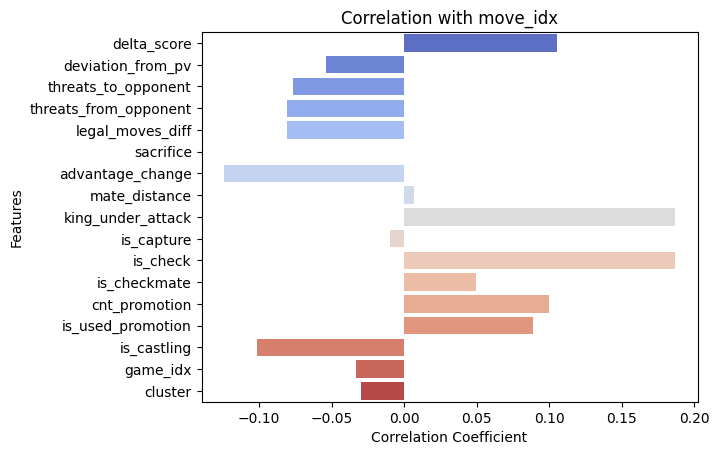

In [13]:
correlation_series = data.drop('move_idx', axis=1).corrwith(data['move_idx'])
sns.barplot(x=correlation_series.values, y=correlation_series.index, hue=correlation_series.index, palette='coolwarm', legend=False)
plt.title('Correlation with move_idx')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

Мне пришла в голову такая идея: а давайте обучим LSTM предсказывать следующий ход, затем прогоним данные через неё и в качестве признакового описания будем брать скрытый слой модели. Скрытый слой содержит информацию о предыдущих ходах, вдруг мы увидим более интересную картину?

> (11.02.2025) Я пока забросил эту идею, хочу попробовать другой подход